# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


# Setting Environment

- Download the .ipynb notebook, open in google colab
 - keep  your csv files in drive
 - specify the path accordigly while reading csv file
 
 
## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 15.5MB/s 
     |████████████████████████████████| 1.1MB 23.2MB/s 
     |████████████████████████████████| 3.0MB 31.4MB/s 


In [ ]:
pip install watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 3.0.2


In [ ]:
import transformers


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch


In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from collections import defaultdict
from textwrap import wrap

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/BERT_Sentiment/Sentiment.csv', encoding = 'latin1')

In [ ]:
df.head()


,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,6.296970e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,6.296970e+17,NaN,Arizona


In [ ]:
df.shape

(13871, 21)

In [ ]:
df.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.612078e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294530e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294860e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296730e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296880e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297020e+17


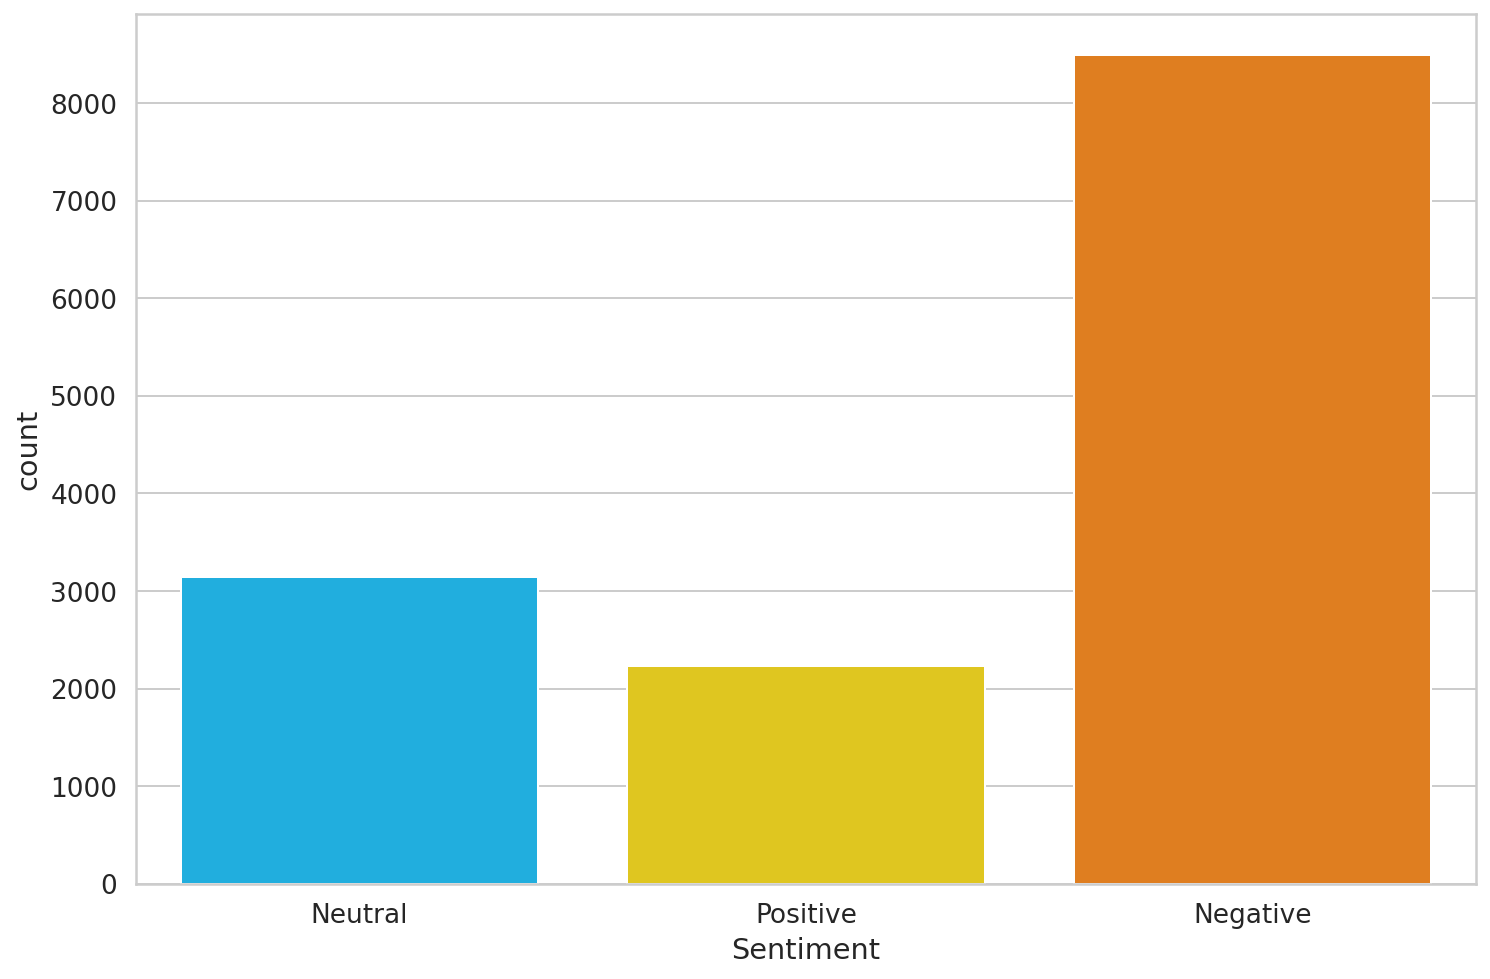

In [ ]:
sns.countplot(df.sentiment)
plt.xlabel('Sentiment');

### **Pre-processing of data**

In [ ]:
# Removing neutral sentiments
# df = df[df.sentiment != "Neutral"]

In [ ]:
# df['sentiment'] = df.sentiment.apply(lambda x: 1 if x=='Positive' else 0)
df['sentiment'] = df.sentiment.apply(lambda x: 1 if x=='Positive' else (0 if x == 'Negative' else 2 ) )

In [ ]:
df.head(3)

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,2,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,1,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,2,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,6.296970e+17,NaN,NaN


In [ ]:
df.shape

(13871, 21)

## **Data Preprocessing**

> Tokenizer



In [ ]:
# enizerPRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
#Loading bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Bert on sample Text

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

In [ ]:
#The position where CLS, SEP, PAD, UNK token inserted

print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]


32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

####  **Getting Max sequence length**





In [ ]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

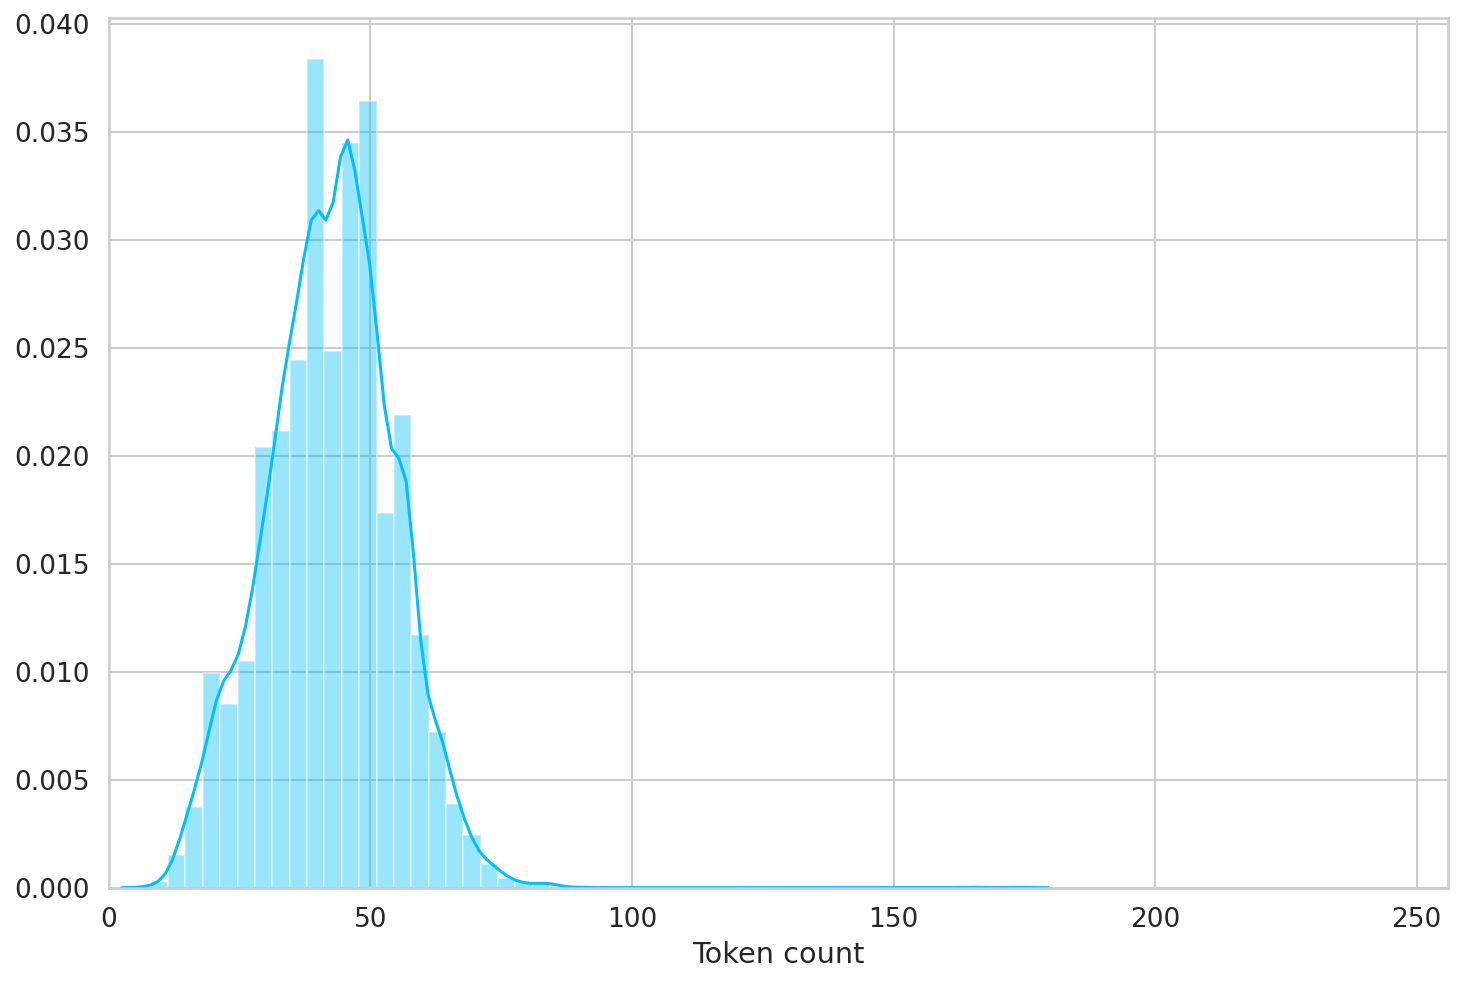

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5,  random_state=RANDOM_SEED) 

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((12483, 21), (694, 21), (694, 21))

**creating data loaders**

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

## Building Bert Model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

**Move the example batch of our training data to the GPU**



In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
model(input_ids, attention_mask)

tensor([[0.4201, 0.1908, 0.3890],
        [0.4834, 0.1647, 0.3519],
        [0.2683, 0.1502, 0.5816],
        [0.5312, 0.1405, 0.3282],
        [0.5866, 0.1966, 0.2168],
        [0.3290, 0.1932, 0.4778],
        [0.4165, 0.1089, 0.4745],
        [0.2975, 0.2678, 0.4347],
        [0.3206, 0.1896, 0.4898],
        [0.2306, 0.2360, 0.5335],
        [0.4016, 0.2009, 0.3976],
        [0.3835, 0.2551, 0.3615],
        [0.5508, 0.0995, 0.3497],
        [0.4678, 0.1911, 0.3412],
        [0.3973, 0.1954, 0.4073],
        [0.3531, 0.2543, 0.3926]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

#### Define a function for model training

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

#### Define a function for Model Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9271733144181333 accuracy 0.6133942161339421
Val   loss 0.9325748600743033 accuracy 0.6195965417867435

Epoch 2/10
----------
Train loss 0.8941535742121073 accuracy 0.6459184490907635
Val   loss 0.9056363038041375 accuracy 0.6455331412103746

Epoch 3/10
----------
Train loss 0.8587884802213857 accuracy 0.6837298726267724
Val   loss 0.8732868283987045 accuracy 0.6743515850144092

Epoch 4/10
----------
Train loss 0.8174372363487371 accuracy 0.730112953616919
Val   loss 0.8664094047112898 accuracy 0.6844380403458212

Epoch 5/10
----------
Train loss 0.7895111381320734 accuracy 0.7602339181286549
Val   loss 0.8541342439976606 accuracy 0.7017291066282421

Epoch 6/10
----------
Train loss 0.7697510423947236 accuracy 0.7792998477929984
Val   loss 0.8538090816952966 accuracy 0.6945244956772334

Epoch 7/10
----------
Train loss 0.7534541937972153 accuracy 0.7968437074421213
Val   loss 0.8538034747947346 accuracy 0.7002881844380403

Epoch 8/10
----------
Train 

Train-validation Accuracy graph

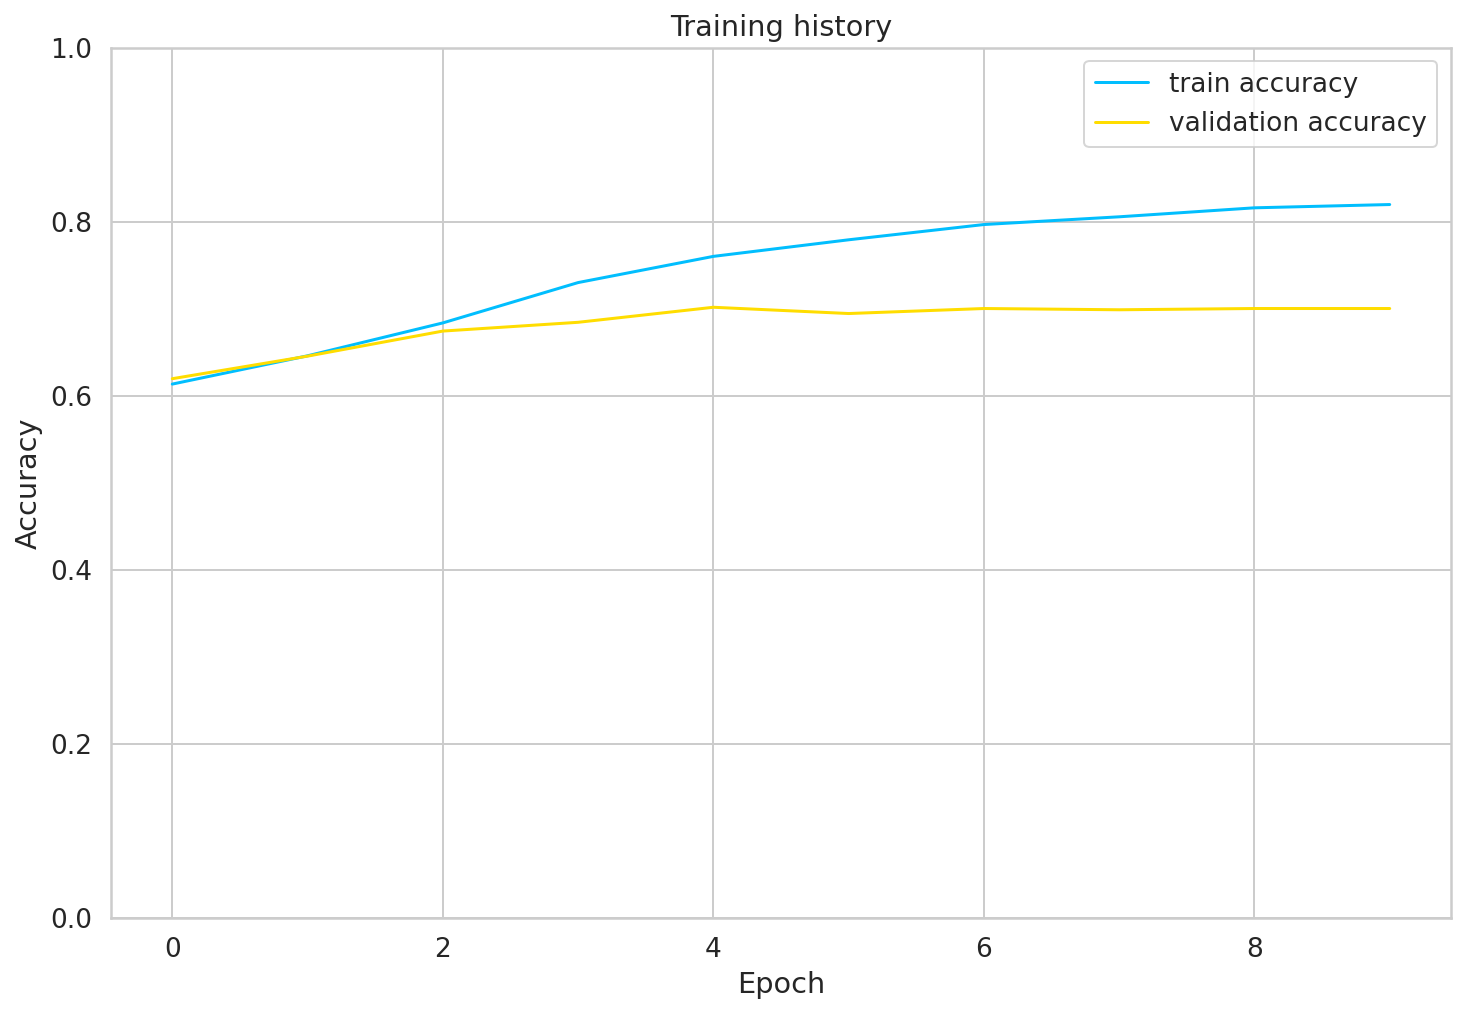

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Test accuracy

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7233429394812679

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

# Evalution

> ***Confusion Matrix***



In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.86      0.81       429
     neutral       0.67      0.58      0.62       124
    positive       0.58      0.43      0.49       141

    accuracy                           0.72       694
   macro avg       0.67      0.62      0.64       694
weighted avg       0.71      0.72      0.71       694



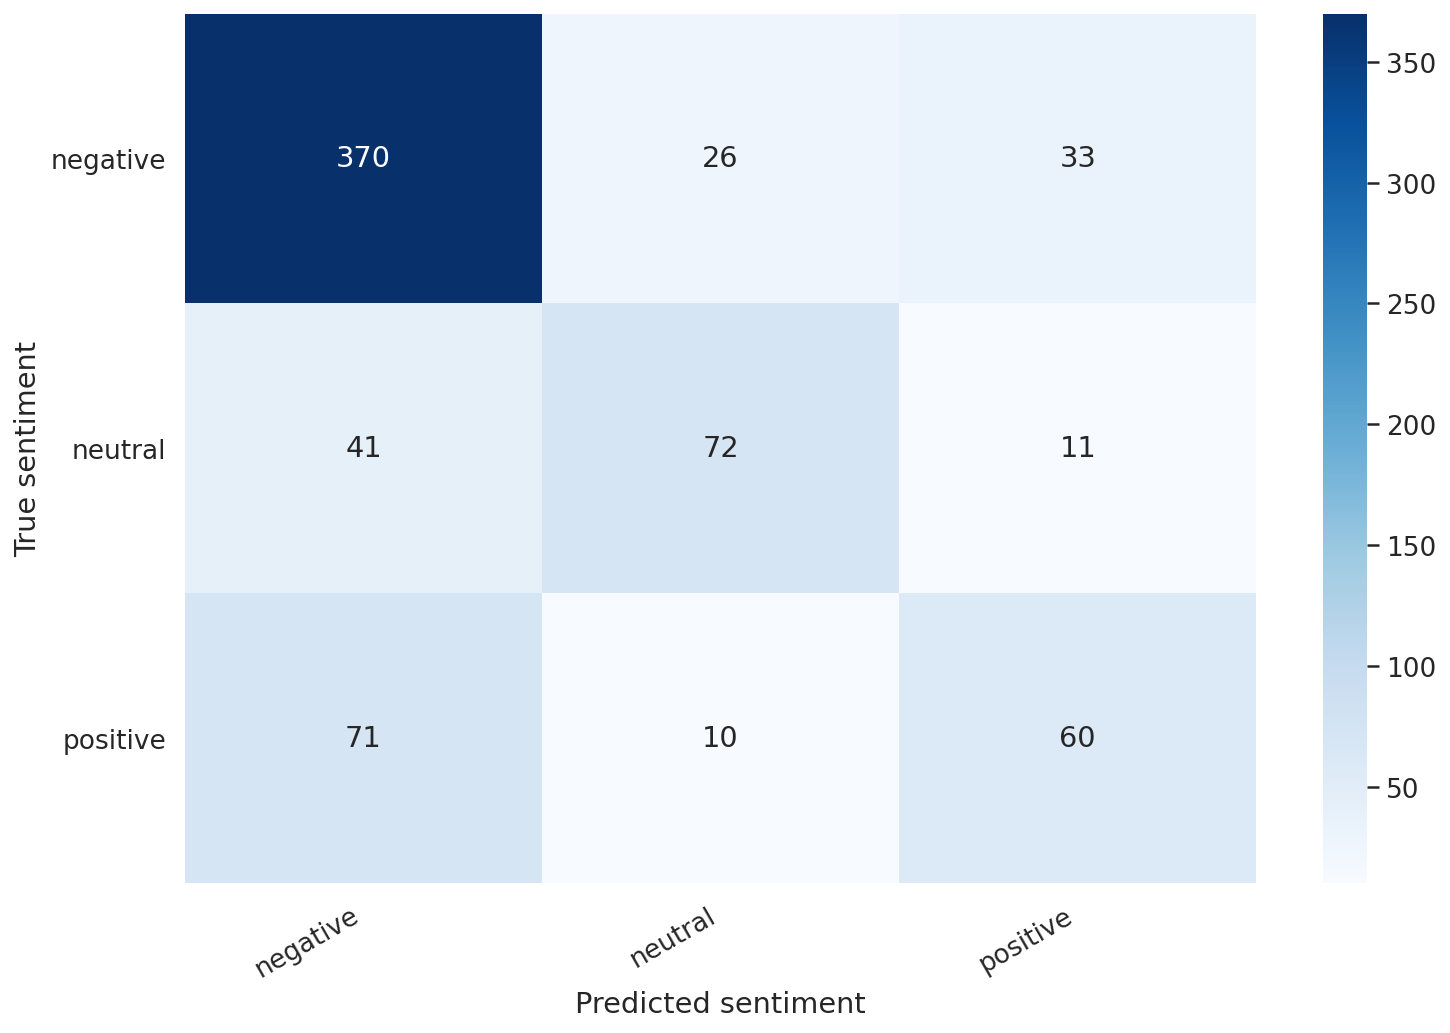

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Example Prediction

In [ ]:
idx = 1

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

RT @RWSurferGirl: Is it just me or does anyone else want to punch
Chris Wallace in the face? #GOPDebate  #GOPDebates ð??ºð??¸

True sentiment: negative


In [ ]:
df_test.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
2019,2020,No candidate mentioned,0.4580,yes,0.6768,1,0.3434,Jobs and Economy,0.4580,NaN,ChrisPfeiffer9,NaN,42,NaN,NaN,RT @MartinOMalley: We must rein in Wall Street...,NaN,2015-08-07 09:35:11 -0700,6.296920e+17,"Doylestown, PA",NaN
11147,11148,No candidate mentioned,1.0000,yes,1.0000,0,1.0000,FOX News or Moderators,1.0000,NaN,sgtlloydusmc,NaN,132,NaN,NaN,RT @RWSurferGirl: Is it just me or does anyone...,NaN,2015-08-06 19:42:32 -0700,6.294830e+17,NaN,Central America
12894,12895,Donald Trump,0.6742,yes,1.0000,0,0.6742,None of the above,1.0000,NaN,flashpointonaol,NaN,149,NaN,NaN,RT @RWSurferGirl: I think Cruz and Trump need ...,NaN,2015-08-06 19:13:41 -0700,6.294750e+17,Maryland,Eastern Time (US & Canada)
2698,2699,Marco Rubio,1.0000,yes,1.0000,1,1.0000,None of the above,1.0000,NaN,BeaverZack,NaN,0,NaN,NaN,@marcorubio did a fantastic job showing why @M...,NaN,2015-08-07 09:27:54 -0700,6.296900e+17,"Indiana, USA",NaN
7936,7937,Chris Christie,1.0000,yes,1.0000,0,1.0000,Foreign Policy,0.3504,NaN,CindyTreadway,NaN,48,NaN,NaN,RT @RWSurferGirl: Tonight we learned that @Gov...,NaN,2015-08-07 09:27:32 -0700,6.296900e+17,NaN,Eastern Time (US & Canada)


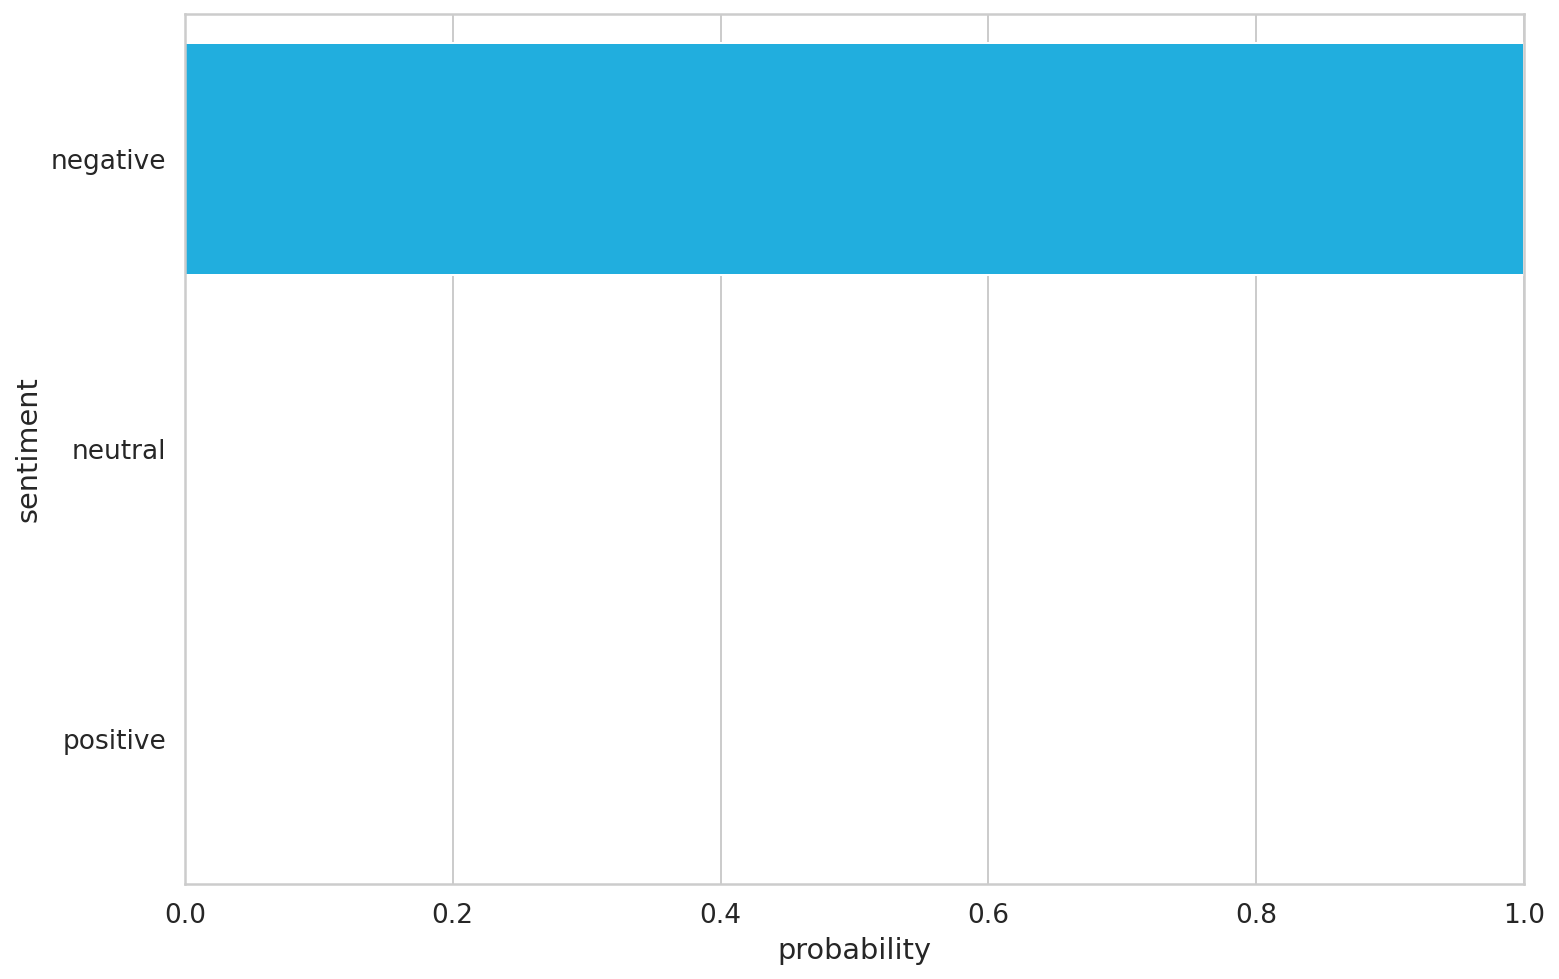

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw text

In [ ]:
review_text = "I don't love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I don't love completing my todos! Best app ever!!!
Sentiment  : negative


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.5755978540000797
GPU (s):
0.19100806599999487
GPU speedup over CPU: 18x


# Predictions on Unseen Data

### Data reading

In [ ]:
ban_tweet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/#BanEVMhashtagTweets.csv', encoding ='latin1')

In [ ]:
chi_tweet_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Batch2/#59ChinesehashtagTweetsPrediction.csv', encoding='latin1')
puthu_tweet_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Batch2/#PuducherryhashtagTweetsPrediction.csv', encoding = 'latin1')
speak_tweet_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Batch2/#SpeakUpAgainstFuelHikehashtagTweetsPreddiction.csv', encoding = 'latin1')

In [ ]:
chi_tweet_df.shape

(900, 16)

In [ ]:
chi_tweet_df.head()

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,TweetType,SVM_Prediction,RF_Prediction,LSTM_Prediction
0,0,RajivRanjanRa16,https://t.co/xmxj2bLugg Alongwith 2.7K Gems so...,Ã¢ÂÂ¡for my post visit my likeÃ¢Â¬Â,841,2792,106928,2018-01-21 08:41:58,2020-07-07 04:25:33,80,First - Surgical strike\n\nSecond - Air Strike...,[],1,Negative,Negative,Positive
1,1,YB_Balasore,This is the Official Twitter Account of yuva B...,NaN,94,157,341,2020-04-22 04:36:55,2020-07-07 04:08:34,21,First -Surgical strike\nSecond -Air Strike\nTh...,[],1,Negative,Negative,Negative
2,2,vijayme10604683,Lok Sabha Television(Parliament of India),"Gurgaon, India",1235,130,2416,2016-06-04 16:02:30,2020-07-07 02:34:28,4652,Government Bans 59 mobile apps which are preju...,[],1,Negative,Negative,Negative
3,3,Harshit80565342,NaN,NaN,85,10,194,2020-02-25 13:01:13,2020-07-07 01:27:45,241,"Listen, then reflect and contemplate upon the ...",[],1,Negative,Negative,Negative
4,4,RidhimaTripath4,Nationalist | Ardent Modi Fan|| Hardcore Hindu...,"Gurgaon, India",890,4545,72505,2018-03-18 08:37:29,2020-07-07 00:52:17,80,First - Surgical strike\n\nSecond - Air Strike...,[],1,Negative,Negative,Positive


### Data Preprocessing

In [ ]:
token_lens = []
for txt in chi_tweet_df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

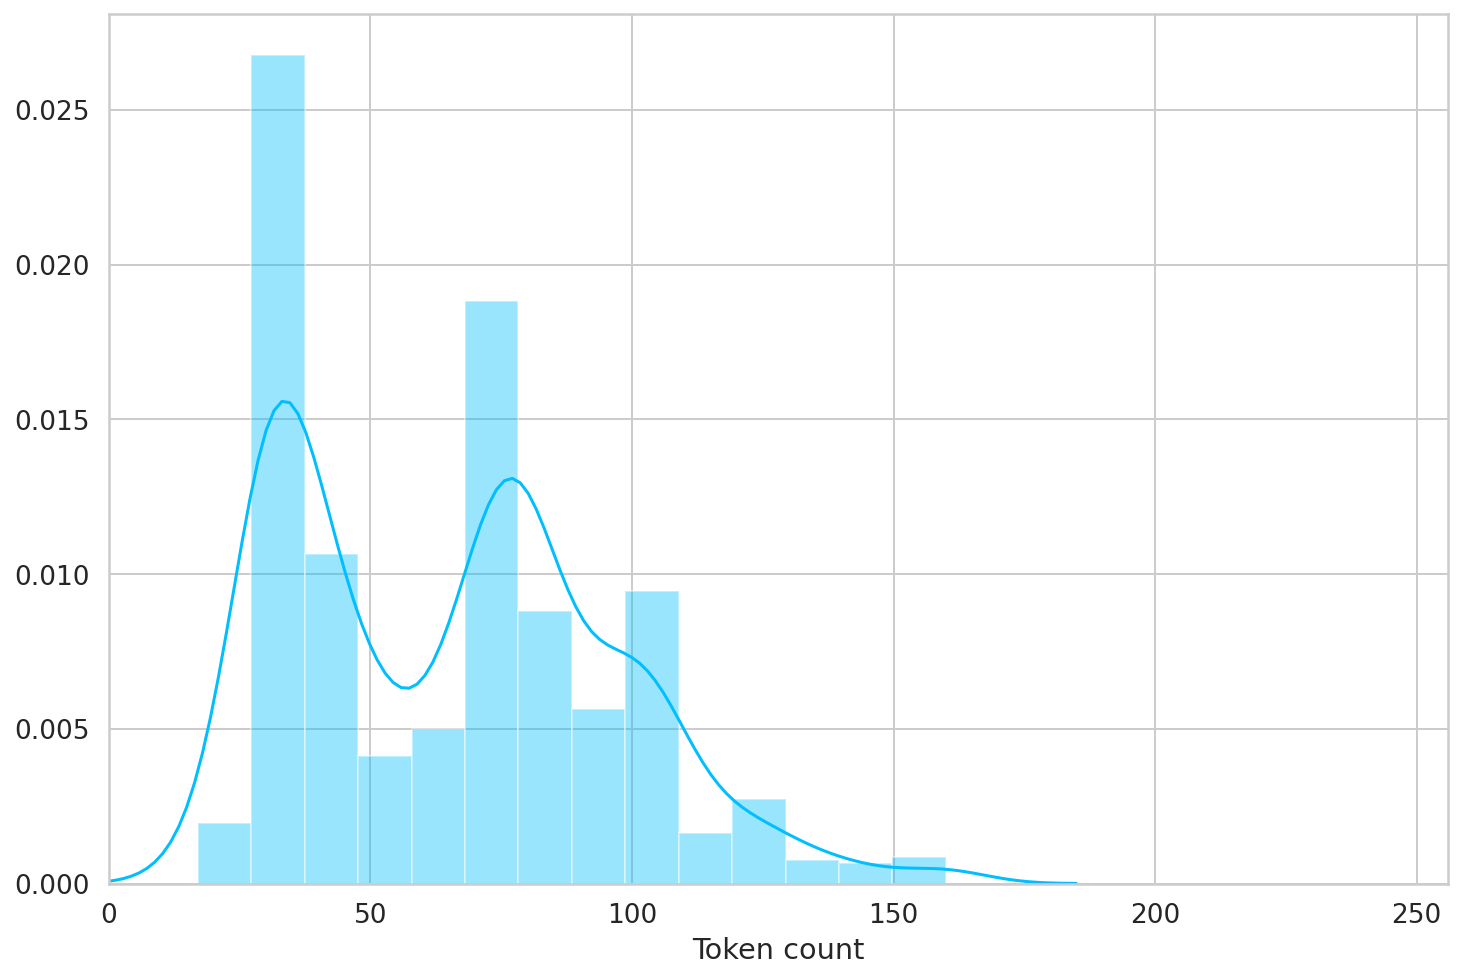

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 200

In [ ]:
class Unseen_preds(Dataset):
  def __init__(self, reviews, tokenizer, max_len):
    self.reviews = reviews
    # self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    # target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      # 'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def Unseen_Dataloader(df, tokenizer, max_len, batch_size):
  ds = Unseen_preds(
    reviews=df.text.to_numpy(),
    
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
data_loader_1 = Unseen_Dataloader(chi_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_2 = Unseen_Dataloader(puthu_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_3 = Unseen_Dataloader(speak_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
BATCH_SIZE = 16

data_loader_1 = Unseen_Dataloader(chi_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_2 = Unseen_Dataloader(puthu_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_3 = Unseen_Dataloader(speak_tweet_df, tokenizer, MAX_LEN, BATCH_SIZE)




***Prediction***

In [ ]:
def Get_unseen_Prediction(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      # targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      # real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  # real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs

### Predictions on tweeter text

In [ ]:
# Getting predictions of all tweet csv file

unsen_review_texts1, unseen_pred_1, unseen_pred_probs_1 = Get_unseen_Prediction(model, data_loader_1)
unsen_review_texts2, unseen_pred_2, unseen_pred_probs_2 = Get_unseen_Prediction(model, data_loader_2 )
unsen_review_texts3, unseen_pred_3, unseen_pred_probs_3 = Get_unseen_Prediction(model, data_loader_3 )

In [ ]:
type(unseen_pred_probs)

torch.Tensor

In [ ]:
def get_type(sentiment_score):
    senti = []
    for i in sentiment_score:
        if i == 1:
            senti.append("Positive")
        elif i == 0:
            senti.append("Negative")
        else:
            senti.append("Nuetral")
    return senti

In [ ]:
sentiment1 = get_type(unseen_pred_1)
sentiment2 = get_type(unseen_pred_2)
sentiment3 = get_type(unseen_pred_3)

In [ ]:
print("59China hastag Predictions: ", unseen_pred_1[:12])
print()
print("Puthucherry hastag Prediction: ", unseen_pred_2[:12])


59China hastag Predictions:  tensor([0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0])

Puthucherry hastag Prediction:  tensor([0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0])


In [ ]:
print(sentiment1[:10])
print(sentiment2[:10])

['Negative', 'Negative', 'Nuetral', 'Nuetral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive']
['Negative', 'Negative', 'Negative', 'Negative', 'Nuetral', 'Negative', 'Nuetral', 'Nuetral', 'Nuetral', 'Nuetral']


**Converting sentiment score into sentiment type**

In [ ]:
chi_tweet_df['BERT_Prediction'] = sentiment1
puthu_tweet_df['BERT_Prediction'] = sentiment2
speak_tweet_df['BERT_Prediction'] = sentiment3

In [ ]:
chi_tweet_df.head(5)

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,TweetType,SVM_Prediction,RF_Prediction,LSTM_Prediction,BERT_Prediction
0,0,RajivRanjanRa16,https://t.co/xmxj2bLugg Alongwith 2.7K Gems so...,Ã¢ÂÂ¡for my post visit my likeÃ¢Â¬Â,841,2792,106928,2018-01-21 08:41:58,2020-07-07 04:25:33,80,First - Surgical strike\n\nSecond - Air Strike...,[],1,Negative,Negative,Positive,Negative
1,1,YB_Balasore,This is the Official Twitter Account of yuva B...,NaN,94,157,341,2020-04-22 04:36:55,2020-07-07 04:08:34,21,First -Surgical strike\nSecond -Air Strike\nTh...,[],1,Negative,Negative,Negative,Negative
2,2,vijayme10604683,Lok Sabha Television(Parliament of India),"Gurgaon, India",1235,130,2416,2016-06-04 16:02:30,2020-07-07 02:34:28,4652,Government Bans 59 mobile apps which are preju...,[],1,Negative,Negative,Negative,Nuetral
3,3,Harshit80565342,NaN,NaN,85,10,194,2020-02-25 13:01:13,2020-07-07 01:27:45,241,"Listen, then reflect and contemplate upon the ...",[],1,Negative,Negative,Negative,Nuetral
4,4,RidhimaTripath4,Nationalist | Ardent Modi Fan|| Hardcore Hindu...,"Gurgaon, India",890,4545,72505,2018-03-18 08:37:29,2020-07-07 00:52:17,80,First - Surgical strike\n\nSecond - Air Strike...,[],1,Negative,Negative,Positive,Negative


In [ ]:
chi_tweet_df.to_csv(r'/content/drive/My Drive/Colab Notebooks/Report/#59ChinesehashtagTweetsPrediction.csv')
puthu_tweet_df.to_csv(r'/content/drive/My Drive/Colab Notebooks/Report/#PuducherryhashtagTweetsPrediction.csv')
speak_tweet_df.to_csv(r'/content/drive/My Drive/Colab Notebooks/Report/#SpeakUpAgainstFuelHikehashtagTweetsPreddiction.csv')

## Miscellaneous

In [ ]:
b = unseen_pred_probs.numpy()
print(b)

[[7.2801979e-03 1.0609277e-02 9.8211056e-01]
 [9.9998057e-01 7.7900131e-06 1.1678590e-05]
 [3.9176931e-04 7.8800513e-04 9.9882025e-01]
 ...
 [9.9997592e-01 1.0044540e-05 1.4120160e-05]
 [6.1203122e-05 5.7298609e-04 9.9936575e-01]
 [9.9997985e-01 8.2306588e-06 1.1935107e-05]]


In [ ]:
sentiment_score = [np.argmax(i) for i in b]

In [ ]:
sent_type[:12]

['Negative',
 'Negative',
 'Nuetral',
 'Nuetral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative']